In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Giới thiệu
Một tổ chức muốn dự đoán ai có thể vỡ nợ cho vay tiêu dùng. Họ có dữ liệu về hành vi lịch sử của khách hàng dựa trên những gì họ đã quan sát. Do đó, khi họ có được khách hàng mới, họ muốn dự đoán ai rủi ro hơn và ai không.

#### Mô tả dữ liệu
-	ID: Mã số duy nhất của người dùng.
-	Income: Thu nhập của người dùng.
-	Age: Tuổi của người dùng.
-	Experience: Kinh nghiệm chuyên môn của người dùng tính bằng năm.
-	Profession: Nghề nghiệp của người dùng.
-	Married/Single: Tình trạng hôn nhân của người dùng, có kết hôn hay chưa.
-	House_Ownership: Tình trạng sở hữu nhà, có sở hữu nhà, thuê nhà hay không sở hữu nhà.
-	Car_Ownership: Người dùng có sở hữu xe hơi hay không.
-	STATE: Bang hoặc vùng lãnh thổ cư trú của người dùng.
-	CITY: Thành phố hoặc khu vực cư trú của người dùng.
-	CURRENT_JOB_YRS: Số năm kinh nghiệm làm việc hiện tại của người dùng.
-	CURRENT_HOUSE_YRS: Số năm cư trú tại địa chỉ hiện tại của người dùng.
-	Risk_Flag: Biến mục tiêu, chỉ liệu người dùng đã gặp rủi ro về việc vỡ nợ hay không.

#### Thêm các thư viện cần thiết

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline
sns.set_theme(color_codes=True, style='darkgrid',
              palette='deep', font='sans-serif')

## Nhập dữ liệu và làm sạch dữ liệu

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/LoanPrediction_ML/Training Data.csv")
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


<b>Khám phá kiểu dữ liệu mỗi cột

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [ ]:
df.describe() # For numerical variables

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [ ]:
numerical_summary = df.describe() # For numerical variables
numerical_columns_count = numerical_summary.shape[1]
print(f'Có tổng cột {numerical_columns_count} cột giá trị số trong tập dữ liệu')

Có tổng cột 7 cột giá trị số trong tập dữ liệu


In [ ]:
df.describe(include=['O']).T  # For categorical variables

,count,unique,top,freq
Married/Single,252000,2,single,226272
House_Ownership,252000,3,rented,231898
Car_Ownership,252000,2,no,176000
Profession,252000,51,Physician,5957
CITY,252000,317,Vijayanagaram,1259
STATE,252000,29,Uttar_Pradesh,28400


In [ ]:
categorical_summary = df.describe(include=['O']).T
categorical_columns_count = categorical_summary.shape[0]
print(f'Có tổng cổng {categorical_columns_count} cột giá trị phân loại trong tập dữ liệu')

Có tổng cổng 6 cột giá trị phân loại trong tập dữ liệu


<b>Kiểm tra giá trị null

In [ ]:
df.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

Không tồn tại giá trị null trong tập dữ liệu!

<b>Kiểm tra trùng lặp

In [ ]:
df.duplicated().sum()

0

Không tồn tại giá trị trùng lặp trong tập dữ liệu

In [ ]:
df.Profession.unique()

array(['Mechanical_engineer', 'Software_Developer', 'Technical_writer',
       'Civil_servant', 'Librarian', 'Economist', 'Flight_attendant',
       'Architect', 'Designer', 'Physician', 'Financial_Analyst',
       'Air_traffic_controller', 'Politician', 'Police_officer', 'Artist',
       'Surveyor', 'Design_Engineer', 'Chemical_engineer',
       'Hotel_Manager', 'Dentist', 'Comedian', 'Biomedical_Engineer',
       'Graphic_Designer', 'Computer_hardware_engineer',
       'Petroleum_Engineer', 'Secretary', 'Computer_operator',
       'Chartered_Accountant', 'Technician', 'Microbiologist',
       'Fashion_Designer', 'Aviator', 'Psychologist', 'Magistrate',
       'Lawyer', 'Firefighter', 'Engineer', 'Official', 'Analyst',
       'Geologist', 'Drafter', 'Statistician', 'Web_designer',
       'Consultant', 'Chef', 'Army_officer', 'Surgeon', 'Scientist',
       'Civil_engineer', 'Industrial_Engineer', 'Technology_specialist'],
      dtype=object)

In [ ]:
df.CITY.unique()

array(['Rewa', 'Parbhani', 'Alappuzha', 'Bhubaneswar',
       'Tiruchirappalli[10]', 'Jalgaon', 'Tiruppur', 'Jamnagar',
       'Kota[6]', 'Karimnagar', 'Hajipur[31]', 'Adoni', 'Erode[17]',
       'Kollam', 'Madurai', 'Anantapuram[24]', 'Kamarhati', 'Bhusawal',
       'Sirsa', 'Amaravati', 'Secunderabad', 'Ahmedabad', 'Ajmer',
       'Ongole', 'Miryalaguda', 'Ambattur', 'Indore', 'Pondicherry',
       'Shimoga', 'Chennai', 'Gulbarga', 'Khammam', 'Saharanpur',
       'Gopalpur', 'Amravati', 'Udupi', 'Howrah', 'Aurangabad[39]',
       'Hospet', 'Shimla', 'Khandwa', 'Bidhannagar', 'Bellary', 'Danapur',
       'Purnia[26]', 'Bijapur', 'Patiala', 'Malda', 'Sagar', 'Durgapur',
       'Junagadh', 'Singrauli', 'Agartala', 'Thanjavur', 'Hindupur',
       'Naihati', 'North_Dumdum', 'Panchkula', 'Anantapur', 'Serampore',
       'Bathinda', 'Nadiad', 'Kanpur', 'Haridwar', 'Berhampur',
       'Jamshedpur', 'Hyderabad', 'Bidar', 'Kottayam', 'Solapur',
       'Suryapet', 'Aizawl', 'Asansol', 'Deoghar'

Một số tên thành phố có các ký tự và số không có ý nghĩa

In [ ]:
df.CITY = df.CITY.str.extract("([A-Za-z]+)")
df.CITY.unique()

array(['Rewa', 'Parbhani', 'Alappuzha', 'Bhubaneswar', 'Tiruchirappalli',
       'Jalgaon', 'Tiruppur', 'Jamnagar', 'Kota', 'Karimnagar', 'Hajipur',
       'Adoni', 'Erode', 'Kollam', 'Madurai', 'Anantapuram', 'Kamarhati',
       'Bhusawal', 'Sirsa', 'Amaravati', 'Secunderabad', 'Ahmedabad',
       'Ajmer', 'Ongole', 'Miryalaguda', 'Ambattur', 'Indore',
       'Pondicherry', 'Shimoga', 'Chennai', 'Gulbarga', 'Khammam',
       'Saharanpur', 'Gopalpur', 'Amravati', 'Udupi', 'Howrah',
       'Aurangabad', 'Hospet', 'Shimla', 'Khandwa', 'Bidhannagar',
       'Bellary', 'Danapur', 'Purnia', 'Bijapur', 'Patiala', 'Malda',
       'Sagar', 'Durgapur', 'Junagadh', 'Singrauli', 'Agartala',
       'Thanjavur', 'Hindupur', 'Naihati', 'North', 'Panchkula',
       'Anantapur', 'Serampore', 'Bathinda', 'Nadiad', 'Kanpur',
       'Haridwar', 'Berhampur', 'Jamshedpur', 'Hyderabad', 'Bidar',
       'Kottayam', 'Solapur', 'Suryapet', 'Aizawl', 'Asansol', 'Deoghar',
       'Eluru', 'Ulhasnagar', 'Aligarh'

In [ ]:
df.STATE.unique()

array(['Madhya_Pradesh', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil_Nadu',
       'Gujarat', 'Rajasthan', 'Telangana', 'Bihar', 'Andhra_Pradesh',
       'West_Bengal', 'Haryana', 'Puducherry', 'Karnataka',
       'Uttar_Pradesh', 'Himachal_Pradesh', 'Punjab', 'Tripura',
       'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam',
       'Jammu_and_Kashmir', 'Delhi', 'Chhattisgarh', 'Chandigarh',
       'Uttar_Pradesh[5]', 'Manipur', 'Sikkim'], dtype=object)

In [ ]:
df.STATE = df.STATE.str.extract("([A-Za-z]+)")
df.STATE.unique()

array(['Madhya', 'Maharashtra', 'Kerala', 'Odisha', 'Tamil', 'Gujarat',
       'Rajasthan', 'Telangana', 'Bihar', 'Andhra', 'West', 'Haryana',
       'Puducherry', 'Karnataka', 'Uttar', 'Himachal', 'Punjab',
       'Tripura', 'Uttarakhand', 'Jharkhand', 'Mizoram', 'Assam', 'Jammu',
       'Delhi', 'Chhattisgarh', 'Chandigarh', 'Manipur', 'Sikkim'],
      dtype=object)

## Trực quan hóa dữ liệu

### Ảnh hưởng của House_Ownership đối với Risk_Flag

In [ ]:
# The average risk percentage whether the customer owned house or not
df.groupby("House_Ownership").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame().T

House_Ownership,rented,norent_noown,owned
Risk_Flag,12.557676,9.952673,8.979718


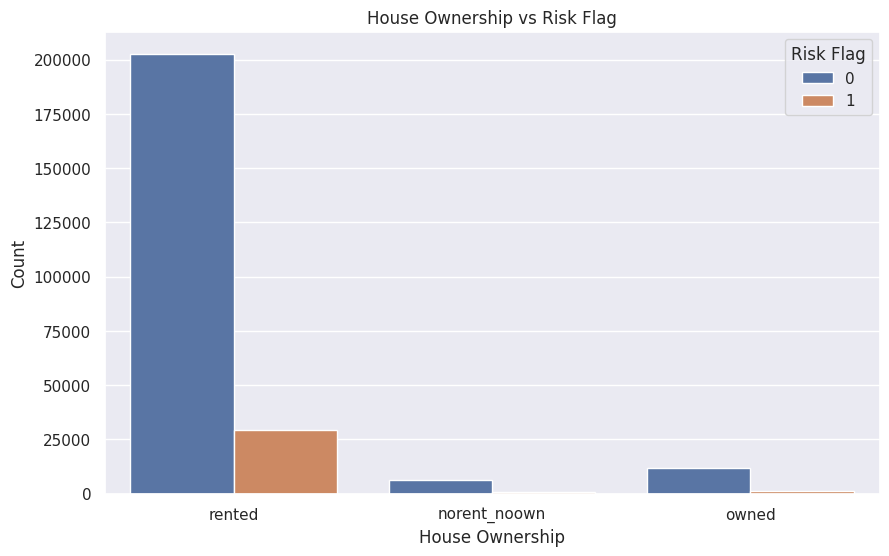

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='House_Ownership', hue='Risk_Flag', data=df)
plt.title('House Ownership vs Risk Flag')
plt.xlabel('House Ownership')
plt.ylabel('Count')
plt.legend(title='Risk Flag')
plt.show()

> Nhận xét

- Phân bố sở hữu nhà: Đa số người trong dữ liệu thuê nhà ('rented'), so với những người sở hữu nhà hoặc không có nhà.

- Rủi ro: Trong mỗi loại sở hữu nhà, số lượng người không có rủi ro (Risk Flag = 0) luôn nhiều hơn người có rủi ro (Risk Flag = 1).

- So sánh giữa các loại sở hữu: Cả ba nhóm đều cho thấy xu hướng tương tự về tỷ lệ giữa rủi ro và không rủi ro, tuy nhiên, nhóm thuê nhà có số lượng người có rủi ro tương đối cao so với tổng số người thuê nhà, điều này có thể liên quan đến đặc điểm tài chính hoặc điều kiện sống ảnh hưởng đến đánh giá rủi ro.

### Ảnh hưởng của Car_Ownership đối với Risk_Flag

In [ ]:
# The average risk percentage whether the customer owned car or not
df.groupby("Car_Ownership").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame().T

Car_Ownership,no,yes
Risk_Flag,12.81875,11.098684


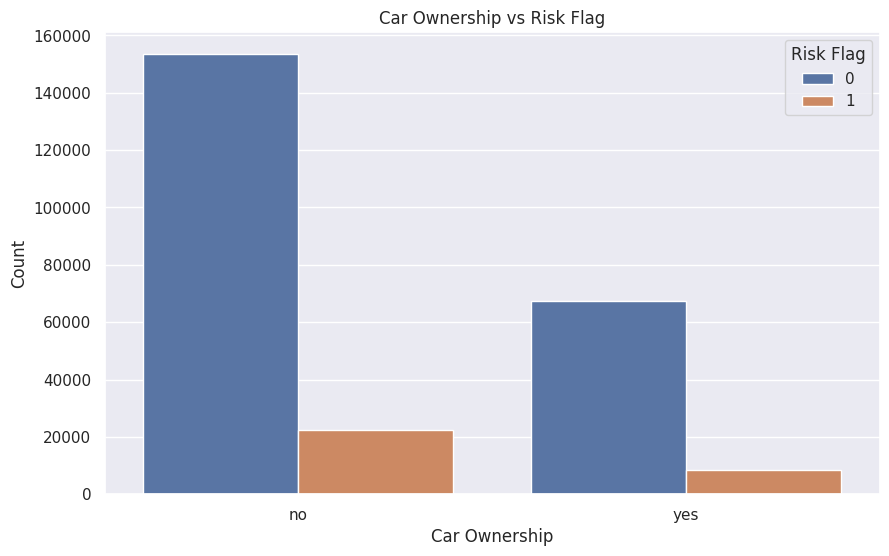

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Car_Ownership', hue='Risk_Flag', data=df)
plt.title('Car Ownership vs Risk Flag')
plt.xlabel('Car Ownership')
plt.ylabel('Count')
plt.legend(title='Risk Flag')
plt.show()

> Nhận xét

- Sự phân bố sở hữu xe hơi: Đa số người trong dữ liệu không sở hữu xe ('no'), so với những người sở hữu xe ('yes').

- Rủi ro: Trong cả hai nhóm sở hữu xe, số lượng người không có rủi ro (Risk Flag = 0) luôn nhiều hơn người có rủi ro (Risk Flag = 1), theo một tỷ lệ tương tự.

- So sánh giữa có và không có xe: Cả hai nhóm có tỷ lệ người có rủi ro so với tổng số người trong mỗi nhóm khá tương đương, điều này có thể cho thấy rằng sở hữu xe không có ảnh hưởng đáng kể đến việc đánh giá rủi ro cá nhân.

### Ảnh hưởng của Married/Single đối với Risk_Flag

In [ ]:
# The average risk percentage whether the customer married or single
df.groupby("Married/Single").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame().T

Married/Single,single,married
Risk_Flag,12.533588,10.245647


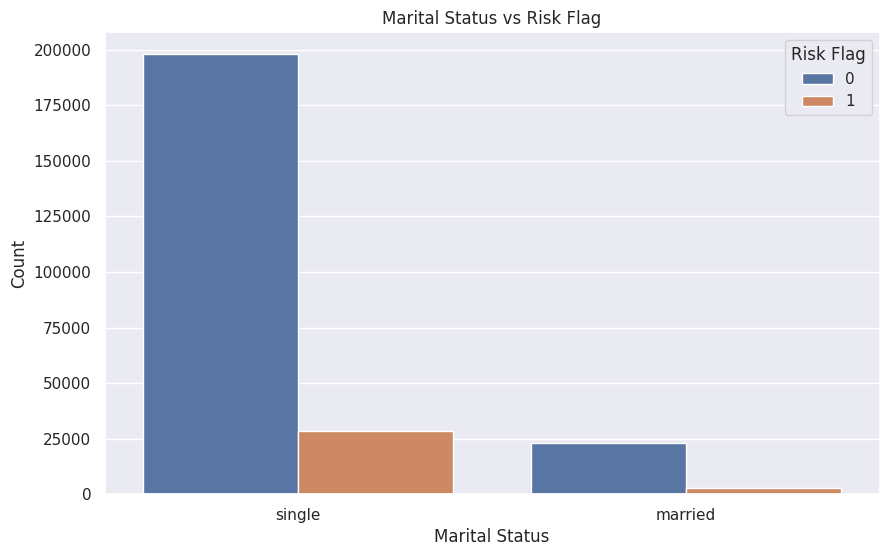

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Married/Single', hue='Risk_Flag', data=df)
plt.title('Marital Status vs Risk Flag')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Risk Flag')
plt.show()

> Nhận xét

- Phân bố tình trạng hôn nhân: Đa số người trong dữ liệu là độc thân ('single'), số lượng này nhiều hơn nhiều so với những người đã kết hôn ('married').

- Rủi ro: Trong cả hai nhóm tình trạng hôn nhân, số lượng người không có rủi ro (Risk Flag = 0) luôn nhiều hơn người có rủi ro (Risk Flag = 1).

- So sánh giữa độc thân và đã kết hôn: Nhóm độc thân có số lượng người có rủi ro tương đối cao so với tổng số người trong nhóm đó. Mặc dù nhóm đã kết hôn có tỷ lệ tương tự, nhưng số lượng tuyệt đối người có rủi ro thấp hơn nhiều do nhóm này ít người hơn.

### Ảnh hưởng của Profession đối với Risk_Flag

In [ ]:
# The average risk percentage of each profession
df.groupby("Profession").Risk_Flag.apply(lambda x: (x.sum() / x.size) * 100).sort_values(ascending=False).to_frame().T

Profession,Police_officer,Chartered_Accountant,Army_officer,Surveyor,Software_Developer,Scientist,Geologist,Civil_engineer,Official,Firefighter,...,Mechanical_engineer,Dentist,Designer,Web_designer,Design_Engineer,Financial_Analyst,Economist,Industrial_Engineer,Petroleum_Engineer,Technology_specialist
Risk_Flag,16.405164,15.357222,15.211328,15.146373,14.842668,14.432127,14.42637,13.583189,13.579643,13.578877,...,11.155837,10.957758,10.91779,10.91347,10.699937,10.315464,9.927837,9.866667,8.510216,8.148617


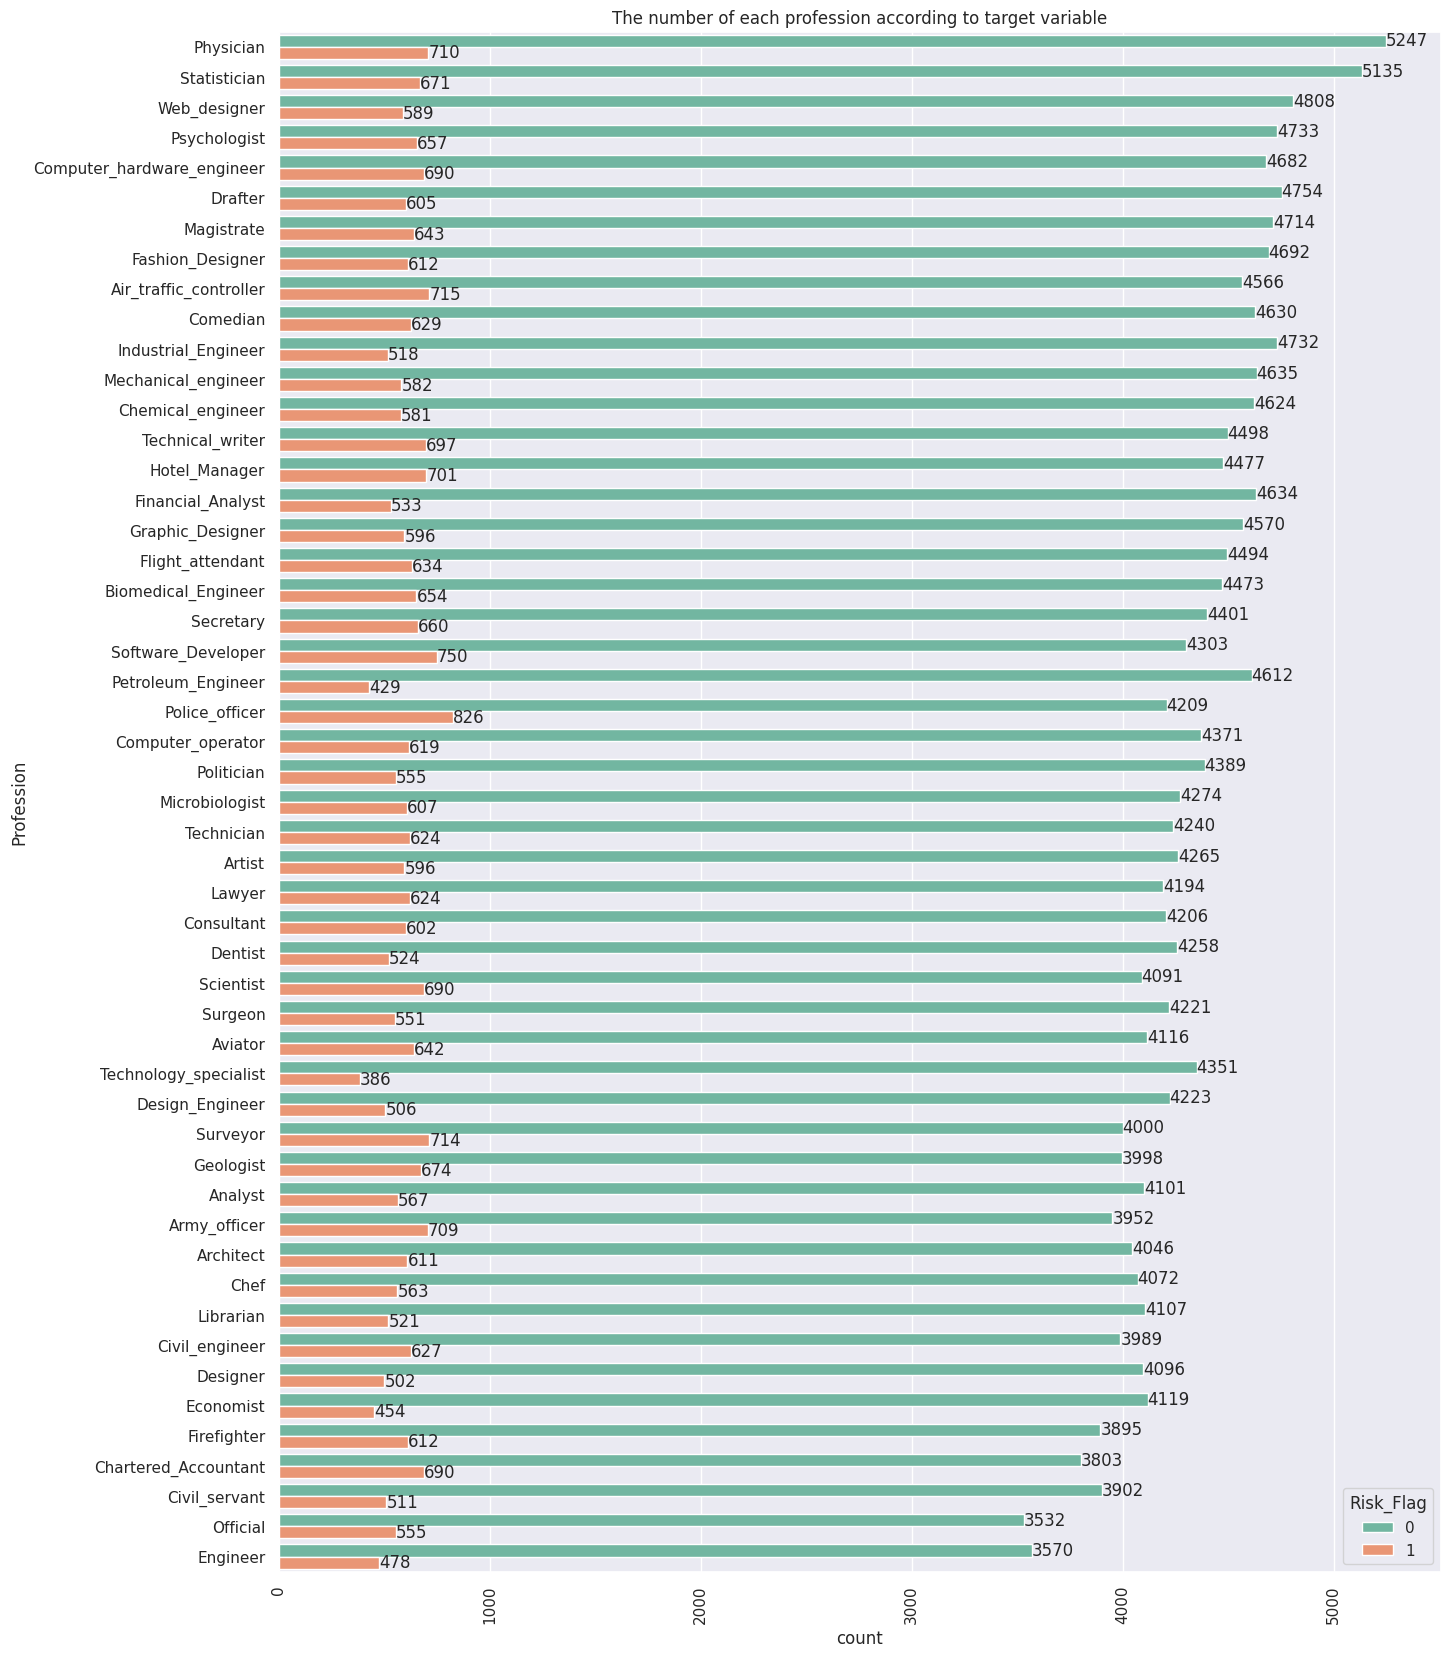

In [ ]:
plt.figure(figsize=(15,20))
ax = sns.countplot(data = df , y=df["Profession"].sort_values(), hue  = "Risk_Flag",order = df['Profession'].value_counts().index, palette="Set2")
plt.xticks(rotation=90)
plt.title('The number of each profession according to target variable')
for bars in ax.containers:
        ax.bar_label(bars);

> Nhận xét

- Đa dạng nghề nghiệp: Biểu đồ thể hiện sự đa dạng của các nghề nghiệp trong tập dữ liệu. Các nghề như Physician, Software_Developer, và Mechanical_engineer có số lượng lớn, cả trong nhóm có rủi ro (Risk_Flag = 1) và không rủi ro (Risk_Flag = 0).

- Phân bố rủi ro: Trong hầu hết các nghề, số lượng cá nhân không có rủi ro (Risk_Flag = 0) luôn nhiều hơn so với những người có rủi ro. Điều này cho thấy, đa số cá nhân trong mỗi nghề được coi là ít rủi ro.

- Các nghề có rủi ro cao: Một số nghề như Civil_servant và Software_Developer có số lượng người có rủi ro đáng kể so với các nghề khác, điều này có thể phản ánh mức độ rủi ro tiềm ẩn cao hơn trong những nghề này.

Biểu đồ này hữu ích để nhận diện các nghề có tỷ lệ rủi ro cao hơn, từ đó có thể hỗ trợ trong việc đánh giá rủi ro và lập kế hoạch quản lý rủi ro dựa trên nghề nghiệp của cá nhân.

### Tỷ lệ phân phối của biến CITY và STATE

In [ ]:
df.groupby(['STATE', "CITY"]).Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False)

STATE        CITY       
Odisha       Bhubaneswar    32.619440
Madhya       Gwalior        27.272727
Bihar        Bettiah        26.695842
Kerala       Kochi          25.286160
West         Raiganj        23.955432
                              ...    
Karnataka    Bangalore       3.713893
             Bijapur         3.496503
Delhi        Sultan          3.409091
Uttarakhand  Dehradun        2.634593
Gujarat      Gandhinagar     2.611367
Name: Risk_Flag, Length: 317, dtype: float64

> Nhận xét

- Bhubaneswar, Odisha: Thành phố này có tỷ lệ rủi ro cao nhất là khoảng 32.62%, điều này cho thấy một tỷ lệ đáng kể các trường hợp có rủi ro trong thành phố này.

- Gwalior, Madhya Pradesh: Tại đây, tỷ lệ rủi ro cũng rất cao, với 27.27%.

- Bettiah, Bihar: Thành phố này có tỷ lệ rủi ro là 26.70%.

- Kochi, Kerala: Một thành phố nổi tiếng khác với tỷ lệ rủi ro là 25.29%.

- Raiganj, West Bengal: Cũng có tỷ lệ rủi ro khá cao là 23.96%.

- Dehradun, Uttarakhand và Gandhinagar, Gujarat có tỷ lệ rủi ro thấp nhất, chỉ khoảng 2.63% và 2.61% tương ứng, cho thấy mức độ an toàn tài chính tốt trong những khu vực này.

Thông tin này có thể giúp đánh giá rủi ro tín dụng dựa trên địa lý và hỗ trợ trong việc phát triển các chiến lược can thiệp hoặc chính sách dựa trên từng khu vực cụ thể.

### Ảnh hưởng của STATE đối với Risk_Flag

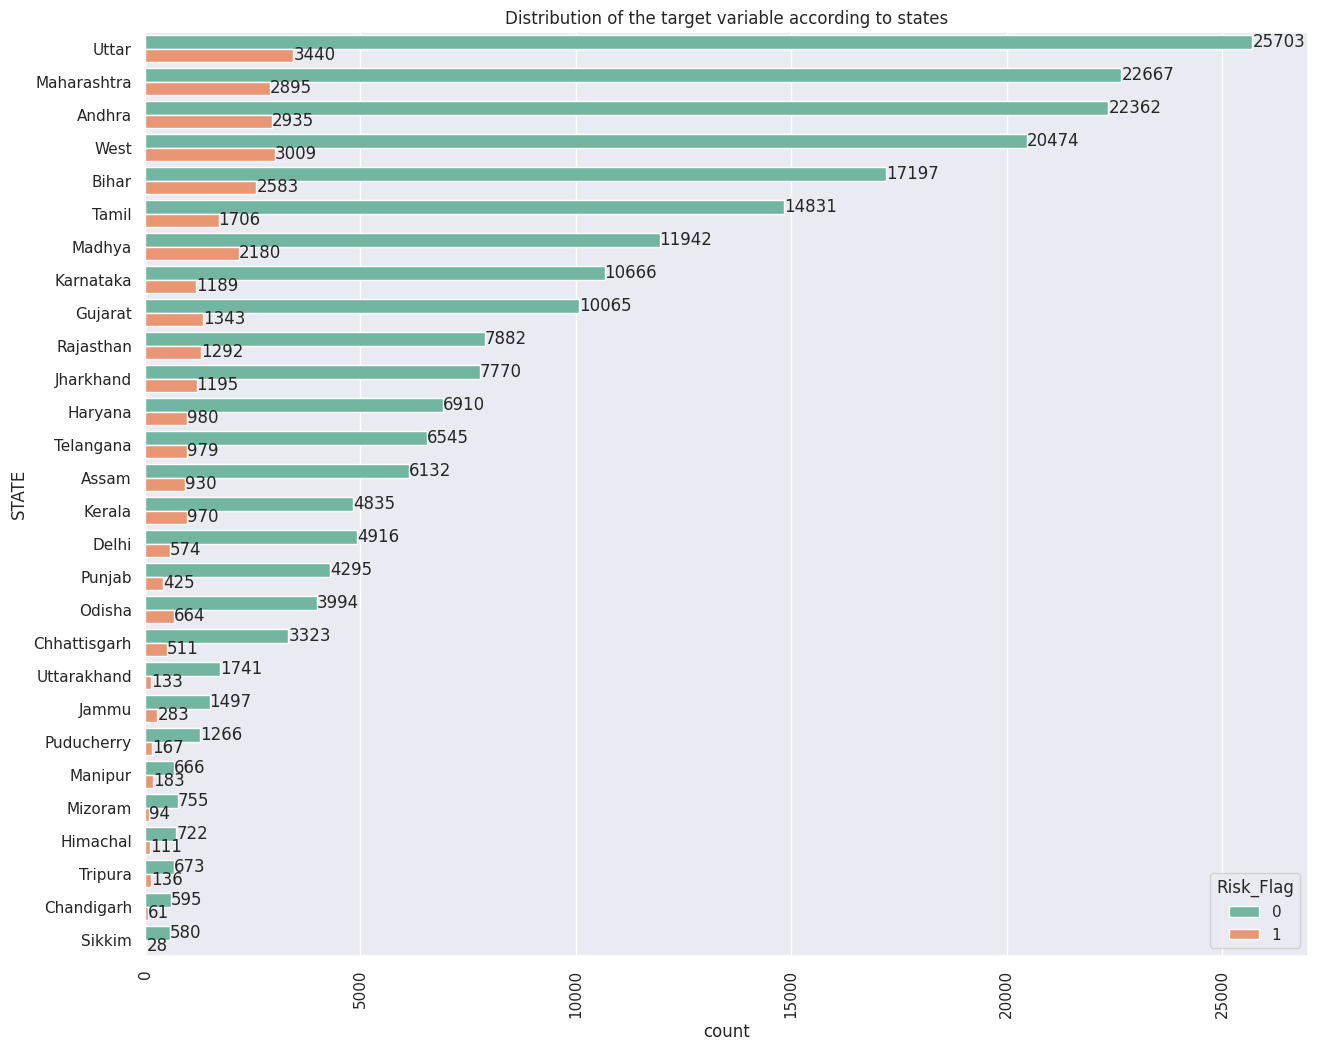

In [ ]:
plt.figure(figsize=(15,12))
ax = sns.countplot(data = df , y=df["STATE"].sort_values(), hue= "Risk_Flag", order=df['STATE'].value_counts().index, palette="Set2")
plt.xticks(rotation=90)
plt.title('Distribution of the target variable according to states')
for bars in ax.containers:
        ax.bar_label(bars);

> Nhận xét

- Sự phân bố tổng quát: Các bang với số lượng mẫu lớn như Uttar Pradesh, Maharashtra, và Andhra Pradesh có số lượng cao cả trong nhóm không rủi ro (Risk_Flag = 0) và có rủi ro (Risk_Flag = 1).

- Sự chênh lệch giữa các bang: Một số bang có tỷ lệ người có rủi ro so với tổng số người cao hơn so với các bang khác. Ví dụ, bang Uttar Pradesh có một lượng lớn các trường hợp có rủi ro, điều này có thể liên quan đến các yếu tố kinh tế - xã hội cụ thể của bang.

- Bang ít rủi ro: Các bang như Kerala và Gujarat dường như có tỷ lệ rủi ro thấp hơn so với tổng số mẫu, điều này cho thấy sự ổn định tài chính hoặc hiệu quả trong việc quản lý rủi ro tại đây.

- Ghi nhận và nhãn: Mỗi cột trong biểu đồ được ghi nhãn rõ ràng với số lượng mỗi nhóm, giúp việc phân tích và so sánh giữa các bang trở nên dễ dàng hơn.

Biểu đồ này cung cấp cái nhìn tổng quan về mức độ phân bố rủi ro tín dụng tại các bang khác nhau, có thể hỗ trợ các nhà hoạch định chính sách hoặc các nhà quản lý rủi ro trong việc đưa ra các quyết định dựa trên bối cảnh địa lý. ​

### Phân phối của biến Age

Dựa trên bảng mô tả dữ liệu dạng số ở trên, ta thấy các thông số của độ tuổi là có các giá trị tính toán cao nhất

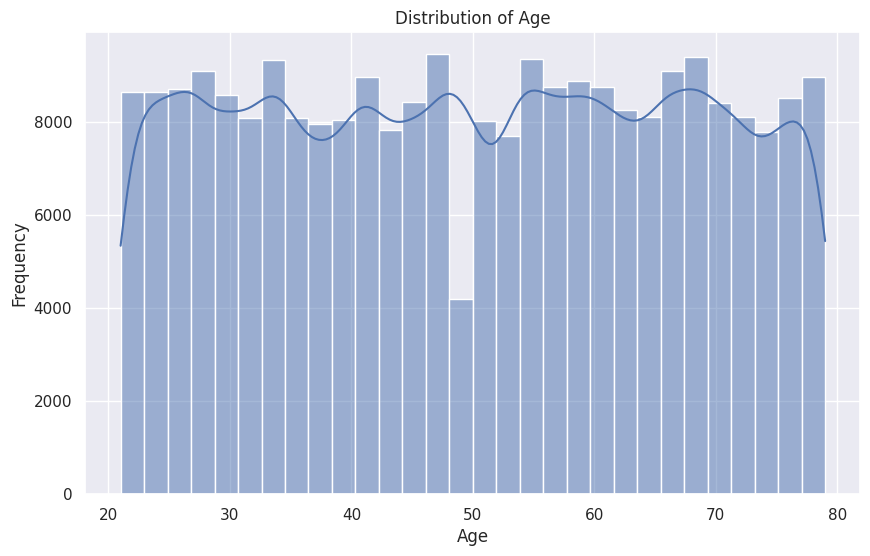

In [ ]:
# Plotting the histogram for the "Age" column
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

> Biểu đồ phân bố tuổi cho thấy một hình dạng khá đều và không có đỉnh rõ ràng, chỉ ra rằng dữ liệu tuổi trong tập dữ liệu được phân bố khá đồng đều qua các nhóm tuổi khác nhau. Có một số biến động nhỏ trong tần suất nhưng không có bất kỳ sự tập trung đáng kể nào vào một nhóm tuổi cụ thể. Điều này có thể cho thấy rằng dữ liệu bao gồm một dân số có độ tuổi khá đa dạng, không thiên về bất kỳ độ tuổi nhất định nào.

### Phân phối của biến Income

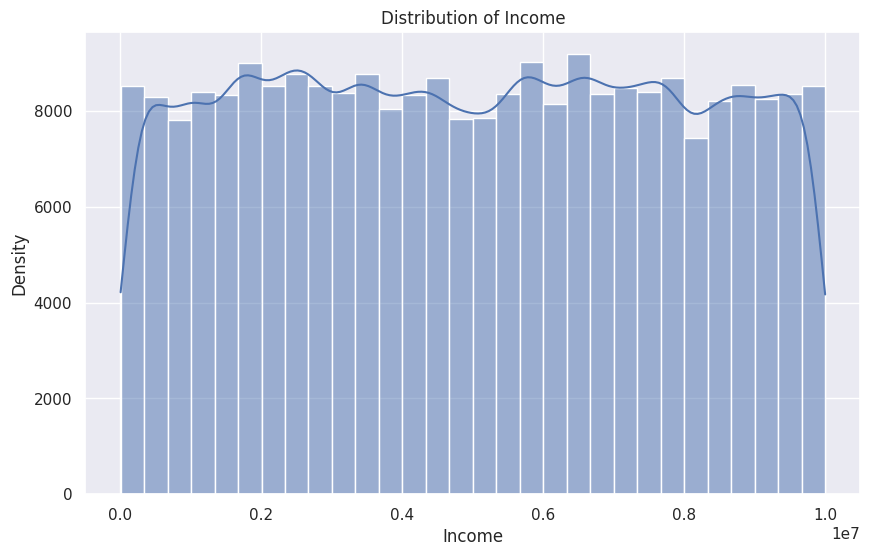

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=True, bins=30)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

> Nhận xét

- Phân bố thu nhập: Thu nhập có phân bố khá đều trên một phạm vi rộng, với một số biến động nhẹ ở các khoảng thu nhập khác nhau.

- Hình dạng của phân bố: Phân bố thu nhập có vẻ gần với phân bố chuẩn, với một đỉnh duy nhất ở giữa. Tuy nhiên, có thể thấy một số biến động nhẹ, cho thấy sự phân bố không hoàn toàn đồng đều.

- Đỉnh của phân bố: Đỉnh của phân bố thu nhập nằm ở khoảng giữa, cho thấy mức thu nhập trung bình có thể là giá trị phổ biến nhất trong dữ liệu.

### Mối quan hệ giữa các biến với nhãn đích

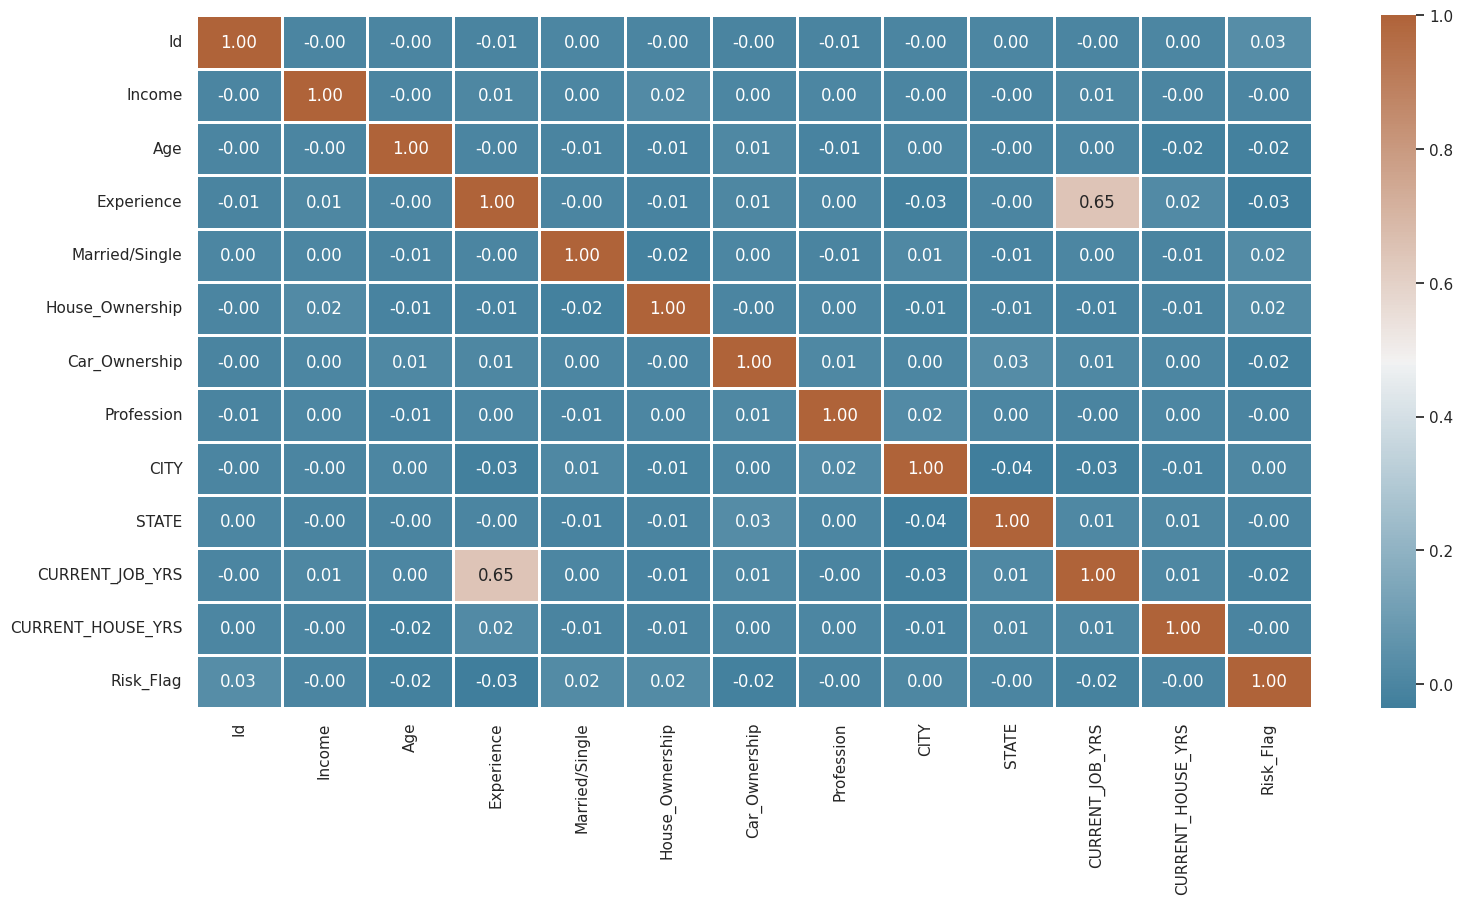

In [ ]:
df_cor = df.copy()

for i in df_cor.columns:
    if df_cor[i].dtype == 'object':
        df_cor[i] = LabelEncoder().fit_transform(df[i])

plt.figure(figsize=(18, 9), facecolor='none')

cmap = sns.diverging_palette(230, 30, as_cmap=True)

size = {"size": 12}

sns.heatmap(
    df_cor.corr(),
    annot=True,
    cmap=cmap,
    square=False,
    linewidths=.9,
    fmt='.2f',
    annot_kws=size,
)
plt.show()

> Nhận xét

- Thu nhập và Tuổi: Có một mức độ tương quan nhỏ giữa Income và Age, cho thấy thu nhập có xu hướng tăng nhẹ theo tuổi.

- Kinh nghiệm và Số năm công việc hiện tại: Có một mối tương quan mạnh giữa Experience và CURRENT_JOB_YRS, điều này là dễ hiểu vì cả hai chỉ số đều liên quan đến thời gian làm việc.

- Rủi ro và các biến khác: Có một mối tương quan nhỏ giữa Risk_Flag và các biến như Married/Single, Car_Ownership, và House_Ownership, cho thấy những yếu tố này có thể ảnh hưởng đến xác suất rủi ro.

- Sở hữu xe và Hôn nhân: Có một mức tương quan nhỏ giữa Car_Ownership và Married/Single, có thể cho thấy những người đã kết hôn có khả năng sở hữu xe hơi cao hơn.

### Kiểm tra giá trị ngoại lai

<Axes: ylabel='Age'>

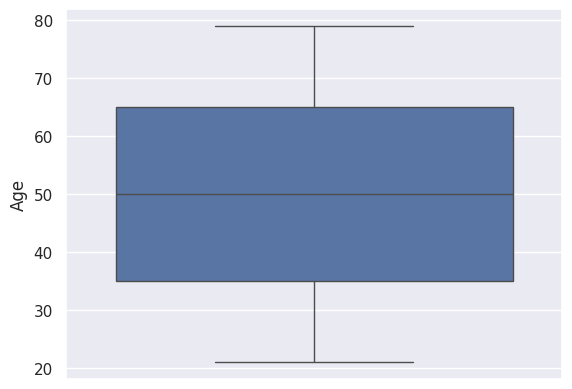

In [ ]:
sns.boxplot(y = 'Age', data = df)

> Không có điểm dữ liệu nào được biểu diễn như ngoại lệ trên biểu đồ, điều này cho thấy không có giá trị tuổi nào quá cao hoặc quá thấp so với phần còn lại của nhóm dữ liệu.

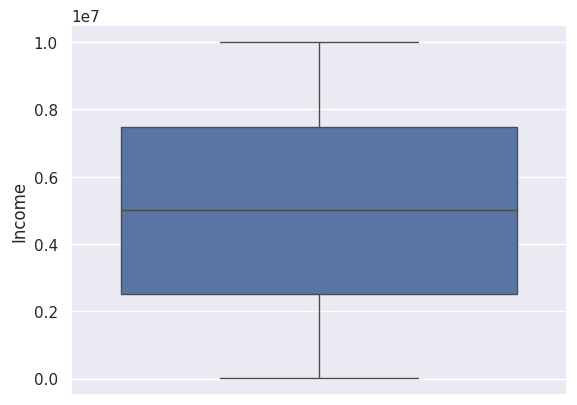

In [ ]:
sns.boxplot(y = 'Income', data = df);

> Không có điểm ngoại lai nào được hiển thị, dữ liệu có thể rất đồng đều và không có giá trị nào quá cao hoặc quá thấp so với phần còn lại của tập dữ liệu

<ipython-input-35-92f3f890dd55>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Risk_Flag', data=df, palette="Set3")


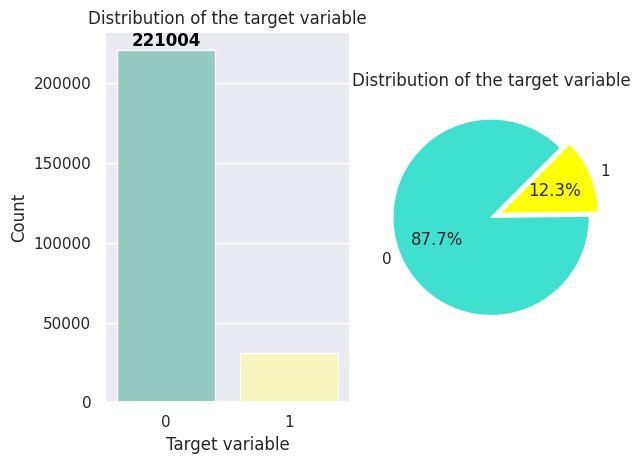

In [ ]:
plt.subplot(1,2,1)
ax = sns.countplot(x='Risk_Flag', data=df, palette="Set3")
plt.title('Distribution of the target variable')
plt.xlabel('Target variable')
plt.ylabel('Count')
ax.bar_label(ax.containers[0], fontsize=12, color='black', fontweight='bold')
plt.subplot(1,2,2)
plt.pie(df.Risk_Flag.value_counts(), labels = df.Risk_Flag.value_counts().index, autopct = '%1.1f%%', startangle = 45, explode = (0, 0.1), colors = ['turquoise', 'yellow'] )
plt.title('Distribution of the target variable')
plt.tight_layout()
plt.show()

### Tóm tắt về trực quan hóa dữ liệu
- Lớp 0 chiếm 88% tập dữ liệu, trong khi lớp 1 chỉ chiếm 12%. Các lớp bị sai lệch rất nhiều, chúng ta cần giải quyết vấn đề này
- Không có ngoại lệ trong tập dữ liệu.
- Mối tương quan chặt chẽ giữa Experience và CURRENT_JOB_YRS. Có thể bỏ một cột trong quá trình lựa chọn tính năng hoặc sử dụng Phân tích thành phần chính (PCA)
- Married/Single House_Ownership Car_Ownership có thể được mã hóa nhị phân hoặc dùng mã hóa one-hot
- Có thể tìm mối liên hệ giữa biến mục tiêu và biến phân loại bằng phép kiểm Chi bình phương

### Feature Engineering

Hàm hỗ trợ kiểm định giả thuyết Chi bình phương

In [ ]:
def chi_square_test(data):
    stat, p, dof, expected = chi2_contingency(data)
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

### Kiểm tra Chi bình phương (Chi Square)

In [ ]:
car_ownership_risk_flag = pd.crosstab(df["Car_Ownership"], df["Risk_Flag"])
car_ownership_risk_flag

Risk_Flag,0,1
Car_Ownership,,
no,153439,22561
yes,67565,8435


In [ ]:
chi_square_test(car_ownership_risk_flag)

p value is 1.7350853850183746e-33
Dependent (reject H0)


In [ ]:
marital_status_risk_flag = pd.crosstab(df["Married/Single"], df["Risk_Flag"])
marital_status_risk_flag

Risk_Flag,0,1
Married/Single,,
married,23092,2636
single,197912,28360


In [ ]:
chi_square_test(marital_status_risk_flag)

p value is 3.773053705715196e-26
Dependent (reject H0)


In [ ]:
house_ownership_risk_flag = pd.crosstab(df["House_Ownership"], df["Risk_Flag"])
house_ownership_risk_flag

Risk_Flag,0,1
House_Ownership,,
norent_noown,6469,715
owned,11758,1160
rented,202777,29121


In [ ]:
chi_square_test(house_ownership_risk_flag)

p value is 1.8381930028370595e-40
Dependent (reject H0)


### Thực hiện phân tích thành phần chính PCA (Principal Component Analysis) cho 2 biến CURRENT_JOB_YRS và Experience

In [ ]:
features = ["CURRENT_JOB_YRS","Experience"]

df_for_pca = df[features]
scaled_df_for_pca = (df_for_pca - df_for_pca.mean(axis=0))/df_for_pca.std()
scaled_df_for_pca

,CURRENT_JOB_YRS,Experience
0,-0.914129,-1.180230
1,0.731035,-0.014067
2,-0.639935,-1.013635
3,-1.188323,-1.346825
4,-0.914129,0.152528
...,...,...
251995,-0.091547,0.485718
251996,-0.091547,-0.014067
251997,0.182647,-0.513851
251998,-1.736711,-1.680014


In [ ]:
pca = PCA()
df_pca = pca.fit_transform(scaled_df_for_pca)
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca = pd.DataFrame(df_pca, columns=component_names)

df_pca.head()

,PC1,PC2
0,-1.480935,-0.188162
1,0.506973,-0.526866
2,-1.169251,-0.264246
3,-1.792620,-0.112078
4,-0.538533,0.754240


In [ ]:
df1 = pd.concat([df,df_pca],axis=1)
df1.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,PC1,PC2
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya,3,13,0,-1.480935,-0.188162
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,0.506973,-0.526866
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,-1.169251,-0.264246
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,-1.792620,-0.112078
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli,Tamil,3,14,1,-0.538533,0.754240


### Chuẩn bị dữ liệu cho quá trình huấn luyện mô hình

Mã hóa nhãn cho các biến phân loại dùng LabelEncoder()

In [ ]:
features = ['Married/Single','Car_Ownership','Profession','CITY','STATE', 'House_Ownership']
label_encoder = LabelEncoder()

for col in features:
    df1[col] = label_encoder.fit_transform(df1[col])

Ta sẽ chọn ra các thuộc tính cần thiết để huấn luyện mô hình

In [ ]:
df2 = df1.drop(["Id", "CURRENT_JOB_YRS", "Experience"],axis=1)
df2

,Income,Age,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_HOUSE_YRS,Risk_Flag,PC1,PC2
0,1303834,23,1,2,0,33,250,13,13,0,-1.480935,-0.188162
1,7574516,40,1,2,0,43,226,14,13,0,0.506973,-0.526866
2,3991815,66,0,2,0,47,8,12,10,0,-1.169251,-0.264246
3,6256451,41,1,2,1,43,53,17,12,1,-1.792620,-0.112078
4,5768871,47,1,2,0,11,295,22,14,1,-0.538533,0.754240
...,...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,1,2,0,45,161,27,11,0,0.278721,0.408188
251996,2843572,26,1,2,0,3,250,13,11,0,-0.074680,0.054787
251997,4522448,46,1,2,0,17,143,14,12,0,-0.234197,-0.492498
251998,6507128,45,1,2,0,27,232,18,10,0,-2.415990,0.040091


#### Chia dữ liệu

In [ ]:
X = df2.drop(['Risk_Flag'],axis=1)
y = df2.Risk_Flag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [ ]:
sm = SMOTE(random_state = 1000)
X_res, y_res = sm.fit_resample(X_train, y_train)

Bây giờ, dữ liệu đã sẵn sàng để thực thi các thuật toán học máy. Do nhãn đích là 0 và 1 nên ta sẽ sử dụng các mô hình phân lớp nhị phân để thực hiện.

### Các mô hình học máy cho phân lớp nhị phân

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter = 500000)
model.fit(X_train_scaled, y_res)
y_pred = model.predict(X_test_scaled)
accuracy_logis = model.score(X_test_scaled, y_test)
accuracy_logis

0.5135978835978836

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.51      0.65     66301
           1       0.13      0.55      0.22      9299

    accuracy                           0.51     75600
   macro avg       0.51      0.53      0.43     75600
weighted avg       0.80      0.51      0.59     75600



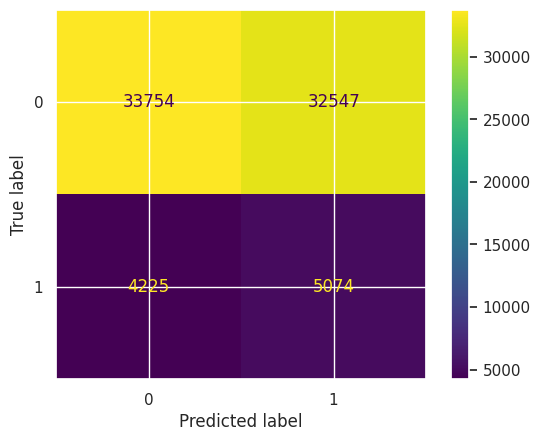

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

con_max = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

> Nhận xét:

- Độ chính xác tổng thể thấp: Mô hình Logistic đạt độ chính xác tổng thể 51%, cho thấy mô hình phân loại đúng khá ít các trường hợp.

- Mô hình này có vẻ tốt hơn trong việc nhận diện khách hàng không vỡ nợ so với việc nhận diện khách hàng vỡ nợ.

- Precision thấp cho lớp vỡ nợ có thể dẫn đến việc từ chối tín dụng cho nhiều khách hàng tiềm năng không vỡ nợ.

- Recall tương đối thấp cho cả hai lớp cho thấy mô hình có thể bỏ qua một số trường hợp thực sự vỡ nợ hoặc không vỡ nợ.


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2],
    'metric': ['minkowski', 'euclidean']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, verbose=3, scoring='accuracy')
grid_search.fit(X_res, y_res)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.610 total time=   4.5s
[CV 2/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.807 total time=   5.9s
[CV 3/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.797 total time=   4.5s
[CV 4/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.790 total time=   4.4s
[CV 5/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.783 total time=   5.8s
[CV 1/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.606 total time=   4.9s
[CV 2/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.803 total time=   5.6s
[CV 3/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.793 total time=   6.1s
[CV 4/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.786 total time=   4.3s
[CV 5/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.778 total time=   4.6s
[CV 1/5] END metric=minkowski, n_neighbors=5, p=1;, score=0.610 total time=   7.2s
[CV 2/5] END metric=minkow

({'metric': 'minkowski', 'n_neighbors': 9, 'p': 1}, 0.7805542010113344)

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=9,metric='minkowski',p=1)
knn_model.fit(X_res, y_res)
y_pred = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test, y_test)
accuracy_knn

0.8653306878306878

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     66301
           1       0.46      0.60      0.52      9299

    accuracy                           0.87     75600
   macro avg       0.70      0.75      0.72     75600
weighted avg       0.88      0.87      0.87     75600



> Nhận xét:

- Độ chính xác tổng thể cao: Mô hình KNN đạt độ chính xác tổng thể 87%, cho thấy mô hình phân loại đúng phần lớn các trường hợp.

- Precision cho lớp 1 thấp: Precision của lớp 1 (các trường hợp có rủi ro) là 0.46, nghĩa là chỉ 46% trong số các dự đoán dương tính là đúng. Điều này cho thấy mô hình có nhiều dự đoán dương tính sai.

- Recall cho lớp 1 tốt hơn: Recall của lớp 1 là 0.61, nghĩa là mô hình tìm được 61% các trường hợp có rủi ro thực sự. Điều này tốt hơn so với mô hình AdaBoost trước đó.

- F1-Score của lớp 1: F1-Score của lớp 1 là 0.53, cho thấy mô hình KNN có sự cân bằng giữa Precision và Recall tốt hơn so với AdaBoost.

- Macro và Weighted Averages: Các chỉ số trung bình (macro và weighted) cho thấy hiệu suất tổng thể của mô hình là ổn định và đáng tin cậy, đặc biệt với weighted avg do sự mất cân bằng giữa hai lớp.

### Random Forest Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#### Sử dụng các thuộc tính quan trọng cho Random Forest

In [ ]:
gr_rf_model = RandomForestClassifier(class_weight="balanced", random_state=101, max_depth=12, n_estimators= 200, min_samples_split = 3)
gr_rf_model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=3, n_estimators=200, random_state=101)

In [ ]:
rf_feature_imp = pd.DataFrame(index = X.columns, data = gr_rf_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
rf_feature_imp

,Feature Importance
Income,0.173059
CITY,0.150847
Age,0.133049
Profession,0.130841
PC1,0.109595
PC2,0.108224
STATE,0.092445
CURRENT_HOUSE_YRS,0.052898
House_Ownership,0.017711
Car_Ownership,0.017574


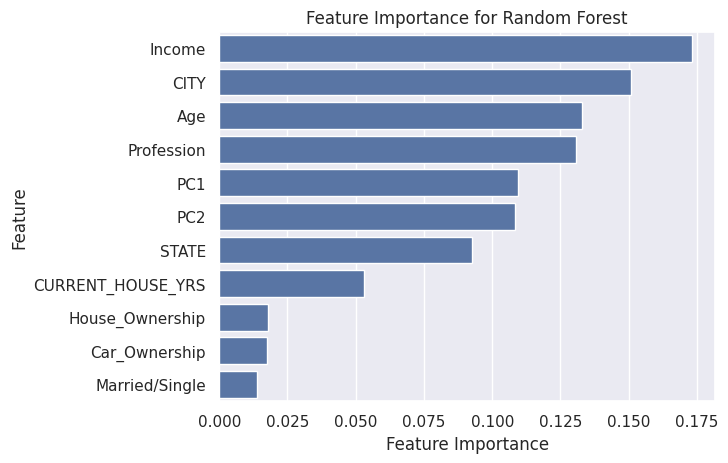

In [ ]:
ax = sns.barplot(x=rf_feature_imp["Feature Importance"], y=rf_feature_imp.index)
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest")
plt.show()

In [ ]:
X_new = X[["Income", "CITY", "Age", "Profession", "PC1", "PC2", "STATE"]]
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y, test_size = 0.3, stratify=y, random_state = 101)

In [ ]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=101)
rf_model.fit(X_train_new,y_train_new)
y_pred_new = rf_model.predict(X_test_new)
accuracy_rf = rf_model.score(X_test_new, y_test_new)
accuracy_rf

0.8958730158730158

In [ ]:
print(classification_report(y_test_new,y_pred_new))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     66301
           1       0.56      0.77      0.64      9299

    accuracy                           0.90     75600
   macro avg       0.76      0.84      0.79     75600
weighted avg       0.91      0.90      0.90     75600



[Text(0.5, 32.249999999999986, 'Predicted Class'),
 Text(91.25, 0.5, 'Actual Class')]

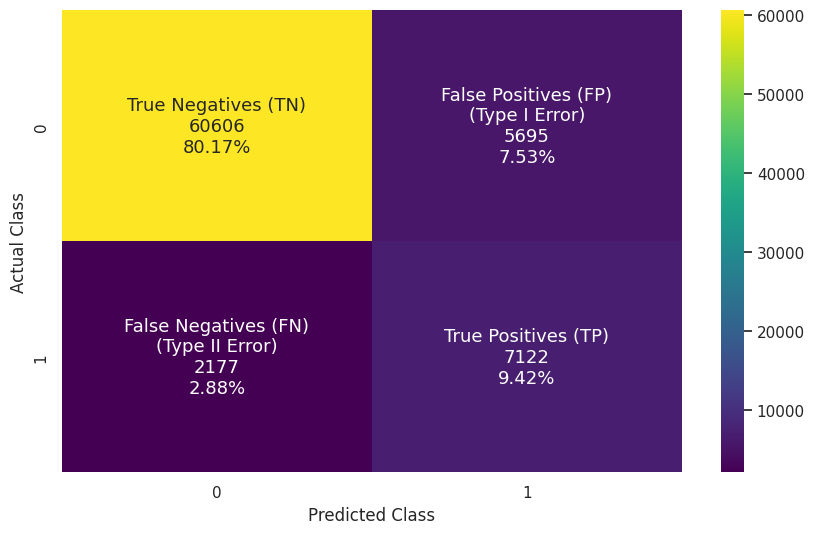

In [ ]:
plt.figure(figsize=(10,6))

y_pred_new = rf_model.predict(X_test_new)
cf_matrix = confusion_matrix(y_test_new, y_pred_new)

group_names = ['True Negatives (TN)', 'False Positives (FP)\n(Type I Error)',
               'False Negatives (FN)\n(Type II Error)', 'True Positives (TP)']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt="", annot_kws={'size': 13}, cmap='viridis')
ax.set(xlabel='Predicted Class', ylabel = 'Actual Class')

> Nhận xét

- True Negatives (TN):

    - Số lượng: 60606
    - Tỷ lệ: 80.17%
    - Đây là số lượng mẫu thuộc lớp 0 (âm tính) mà mô hình dự đoán chính xác là âm tính. Con số này khá lớn, cho thấy mô hình có khả năng phát hiện các trường hợp âm tính khá tốt.

- False Positives (FP) (Type I Error):

    - Số lượng: 5695
    - Tỷ lệ: 7.53%
    - Đây là số lượng mẫu thuộc lớp 0 nhưng mô hình lại dự đoán là lớp 1 (dương tính). Tỷ lệ này không quá cao, nhưng vẫn cần được cải thiện để giảm thiểu các dự đoán sai lệch.

- False Negatives (FN) (Type II Error):

    - Số lượng: 2177
    - Tỷ lệ: 2.88%
    - Đây là số lượng mẫu thuộc lớp 1 (dương tính) nhưng mô hình lại dự đoán là lớp 0. Tỷ lệ này khá thấp, cho thấy mô hình có khả năng phát hiện các trường hợp dương tính tốt, nhưng vẫn còn một số trường hợp bị bỏ sót.

- True Positives (TP):

    - Số lượng: 7122
    - Tỷ lệ: 9.42%
    - Đây là số lượng mẫu thuộc lớp 1 mà mô hình dự đoán chính xác là dương tính. Tỷ lệ này thể hiện khả năng của mô hình trong việc nhận diện các trường hợp dương tính.

Tổng quan:

- Mô hình Random Forest này có độ chính xác tương đối cao trong việc nhận diện các trường hợp âm tính (TN) và dương tính (TP).
- Số lượng FP và FN không quá cao, nhưng vẫn cần được chú ý để cải thiện hơn nữa.
- Để cải thiện mô hình, nên xem xét việc cân bằng lại dữ liệu (data balancing).

### AdaBoost Classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(estimator=AdaBoostClassifier(random_state=15000), param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_res)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

accuracy_ada = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_best)

print(f"Test Set Accuracy: {accuracy_ada}")
print(f"Test Set Precision: {precision_best}")
print(f"Test Set Recall: {recall_best}")
print(f"Test Set F1-score: {f1_best}")
print(f"Test Set ROC-AUC: {roc_auc_best}")

print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'learning_rate': 1, 'n_estimators': 150}
Best Cross-Validation Score: 0.5953246830237127
Test Set Accuracy: 0.564047619047619
Test Set Precision: 0.1461094324946899
Test Set Recall: 0.525217765351113
Test Set F1-score: 0.22861957590226092
Test Set ROC-AUC: 0.5473557190731976
Confusion Matrix for Best Model:
[[37758 28543]
 [ 4415  4884]]

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.90      0.57      0.70     66301
           1       0.15      0.53      0.23      9299

    accuracy                           0.56     75600
   macro avg       0.52      0.55      0.46     75600
weighted avg       0.80      0.56      0.64     75600



> Nhận xét:

- Độ chính xác (Accuracy): Mô hình đạt độ chính xác tổng thể là 56%, thấp hơn so với kỳ vọng cho một mô hình dự đoán rủi ro.

- Precision và Recall (lớp 1): Precision cho lớp 1 (các trường hợp có rủi ro) là 0.15, nghĩa là mô hình chỉ đúng 15% khi dự đoán là có rủi ro. Recall là 0.53, nghĩa là mô hình tìm được 53% các trường hợp có rủi ro thực sự.

- F1-Score (lớp 1): F1-Score cho lớp 1 là 0.23, cho thấy sự cân bằng giữa Precision và Recall không tốt.

- ROC-AUC: Điểm ROC-AUC là 0.547, cho thấy mô hình chỉ hơi tốt hơn một chút so với dự đoán ngẫu nhiên.

### Gradient Boosting

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

model = GradientBoostingClassifier()

grid_search = GridSearchCV(model, param_grid, cv=3, verbose=2)

grid_search.fit(X_train_scaled, y_res)

best_params = grid_search.best_params_

best_model = GradientBoostingClassifier(**best_params)

best_model.fit(X_train_scaled, y_res)

accuracy_gra = best_model.score(X_test_scaled, y_test)
accuracy_gra

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  20.1s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  19.6s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  19.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  41.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  41.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  40.5s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  30.7s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  32.4s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  30.6s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 1.0min
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time= 1.0min
[CV] END ..learning_rate=0.01, max_depth=5, n_est

0.6973809523809524

In [ ]:
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80     66301
           1       0.24      0.69      0.36      9299

    accuracy                           0.70     75600
   macro avg       0.59      0.69      0.58     75600
weighted avg       0.86      0.70      0.75     75600



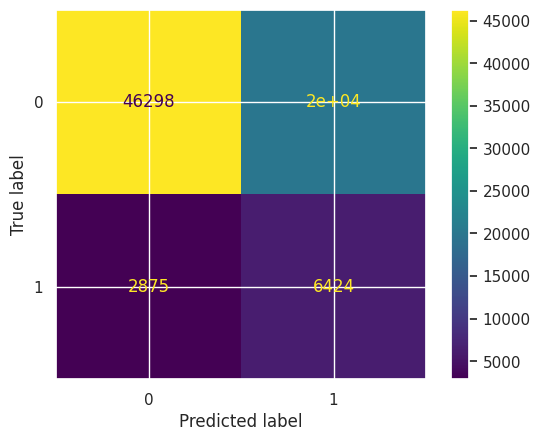

In [ ]:
con_max = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

-	Lớp 0 (Không vỡ nợ):
  + Precision cao (0.94): Khi mô hình dự đoán một khách hàng không vỡ nợ, nó chính xác đến 94%.
  + Recall thấp hơn (0.70): Có 70% của tổng số khách hàng thực sự không vỡ nợ được mô hình dự đoán chính xác.
  + F1-score (0.80): Điểm số này cho thấy một sự cân bằng giữa precision và recall, nhưng vẫn có không gian để cải thiện, đặc biệt là về mặt recall.
-	Lớp 1 (Vỡ nợ):
  + Precision thấp (0.24): Chỉ có 24% trong số những dự đoán vỡ nợ của mô hình là chính xác.
  + Recall cao hơn (0.69): Mô hình có khả năng nhận diện 69% của những trường hợp thực sự vỡ nợ.
  + F1-score thấp (0.36): Điểm số này cho thấy mô hình không hiệu quả lắm trong việc dự đoán lớp vỡ nợ, chủ yếu do precision thấp.
- Accuracy tổng thể (0.70): Mô hình chính xác 70% trên toàn bộ dữ liệu kiểm tra.

- Nhận xét chung:
  + Mô hình có vẻ tốt trong việc nhận diện khách hàng không vỡ nợ nhưng không hiệu quả trong việc nhận diện khách hàng vỡ nợ.
  + Precision thấp cho lớp 1 có thể dẫn đến việc từ chối tín dụng cho nhiều khách hàng tiềm năng không vỡ nợ.


### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', GaussianNB(var_smoothing=1e-8))
])


# Huấn luyện mô hình với pipeline
pipeline.fit(X_res, y_res)

# Dự đoán trên tập kiểm tra và tính toán độ chính xác
y_pred = pipeline.predict(X_test)
accuracy_naive = pipeline.score(X_test, y_test)

print("Accuracy:", accuracy_naive)
print(classification_report(y_test,y_pred))


Accuracy: 0.4720634920634921
              precision    recall  f1-score   support

           0       0.89      0.46      0.60     66301
           1       0.13      0.59      0.22      9299

    accuracy                           0.47     75600
   macro avg       0.51      0.52      0.41     75600
weighted avg       0.80      0.47      0.55     75600



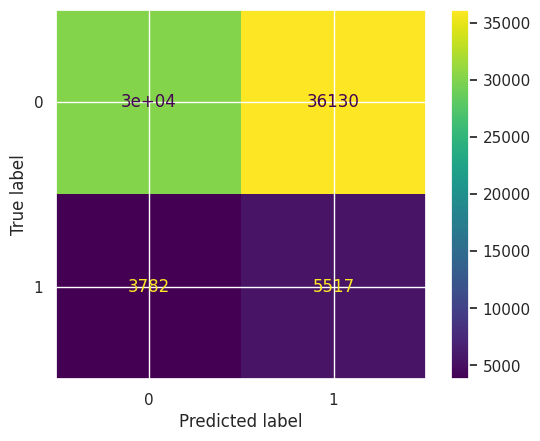

In [ ]:
con_max = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

- Lớp 0 (Không vỡ nợ):
  + Precision cao (0.89): Khi mô hình dự đoán một khách hàng không vỡ nợ chính xác đến 89%
  + Recall thấp (0.46): Có 46% của tổng số khách hàng thực sự không vỡ nợ được mô hình dự đoán chính xác.
  + F1-score cao hơn (0.6): Điểm số này cho thấy mô hình dự đoán chính xác 60% lớp không vỡ nợ, chủ yếu do recall thấp.
-	Lớp 1 (Vỡ nợ):
  + Precision thấp (0.13): Chỉ có 13% trong số những dự đoán vỡ nợ của mô hình là chính xác.
  + Recall cao hơn (0.59): Mô hình có khả năng nhận diện 59% của những trường hợp thực sự vỡ nợ.
  + F1-score thấp (0.22): Điểm số này cho thấy mô hình không hiệu quả lắm trong việc dự đoán lớp vỡ nợ, chủ yếu do precision rất thấp.
- Accuracy tổng thể (0.47): Mô hình chính xác 47% trên toàn bộ dữ liệu kiểm tra.

- Nhận xét chung:
  + Mô hình này có vẻ không cân bằng giữa hai lớp. Mặc dù có precision cao cho lớp không vỡ nợ, nhưng recall thấp cho thấy mô hình bỏ qua nhiều trường hợp thực sự không vỡ nợ.
  + Đối với lớp vỡ nợ, mô hình có recall cao nhưng precision rất thấp, điều này có nghĩa là mô hình dự đoán quá nhiều trường hợp là vỡ nợ khi chúng không phải, dẫn đến nhiều báo động giả.
  + Độ chính xác tổng thể thấp cho thấy mô hình này có thể không phù hợp để đưa ra quyết định về việc cấp tín dụng.


### Kết luận
Random Forest phù hợp nhất với tập dữ liệu với độ chính xác lên đến 90%


### Build model ANNs

#### Define data for ANNs model

In [ ]:
# import for model
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
import joblib
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

In [ ]:
ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='elu', kernel_initializer='he_normal', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(32, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               3072      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [ ]:
# Compile the model
ann_model.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
import time
n_epochs = 23
new_training = 1
time_chay = 0
if new_training:
    model_saver = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/ann_model.h5',monitor='val_accuracy', save_best_only=True)
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    performance_sched = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2)
    #with tf.device('/gpu:0'):
    start_time = time.time()
    history = ann_model.fit(X_train_scaled, y_res, epochs=n_epochs,
                              batch_size=32,
                              validation_split = 0.1,
                              callbacks=[model_saver, early_stopper, performance_sched], verbose=1)
    end_time = time.time()
    time_chay = end_time - start_time
    print("Thời gian chạy: ", time_chay)
    history = history.history
    joblib.dump(history,'/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/history_ann_model')
else:
    try:
        ann_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/ann_model.h5')
        history = joblib.load('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/history_ann_model')
    except Exception as e:
        history = joblib.load('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/history_ann_model')

history.keys()
print("Train_Accuracy:", history['accuracy'][-1])
print("Val_Accuracy:", history['val_accuracy'][-1])
#endregion

Epoch 1/23
8696/8703 [============================>.] - ETA: 0s - loss: 0.6347 - accuracy: 0.6305

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8703/8703 [==============================] - 44s 4ms/step - loss: 0.6347 - accuracy: 0.6306 - val_loss: 0.6372 - val_accuracy: 0.6632 - lr: 0.0010
Epoch 2/23
8703/8703 [==============================] - 38s 4ms/step - loss: 0.5489 - accuracy: 0.7219 - val_loss: 0.5235 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 3/23
8703/8703 [==============================] - 40s 5ms/step - loss: 0.4981 - accuracy: 0.7649 - val_loss: 0.4668 - val_accuracy: 0.8253 - lr: 0.0010
Epoch 4/23
8703/8703 [==============================] - 38s 4ms/step - loss: 0.4652 - accuracy: 0.7907 - val_loss: 0.4141 - val_accuracy: 0.8579 - lr: 0.0010
Epoch 5/23
8703/8703 [==============================] - 37s 4ms/step - loss: 0.4436 - accuracy: 0.8076 - val_loss: 0.3602 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 6/23
8703/8703 [==============================] - 40s 5ms/step - loss: 0.4281 - accuracy: 0.8182 - val_loss: 0.3524 - val_accuracy: 0.8857 - lr: 0.0010
Epoch 7/23
8703/8703 [==============================] - 37s 4ms

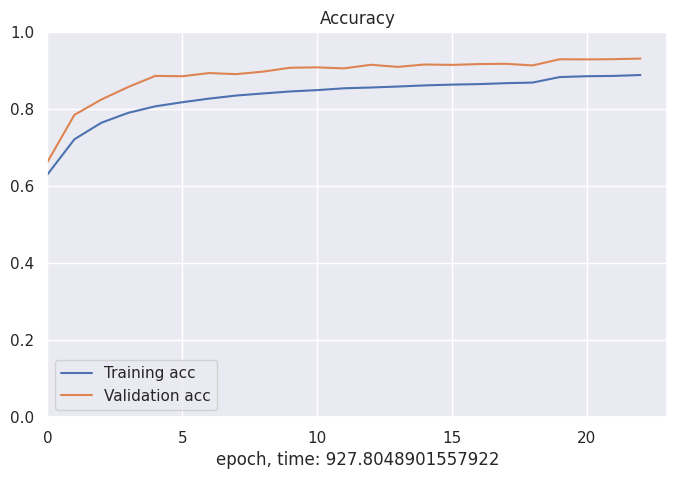

In [ ]:
# %% Plot learning curves
import pandas as pd
pd.DataFrame({'Training acc':history['accuracy'],'Validation acc':history['val_accuracy']}).plot(figsize=(8, 5))
plt.grid(True)
plt.xlim(0, n_epochs)
plt.ylim(0, 1)
plt.xlabel(f'epoch, time: {time_chay}') # train lại làm mất time chạy
plt.xticks(np.arange(0,n_epochs+1,5))
plt.savefig("/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/ann_model") # Dùng hình ảnh để lưu, và thay đổi tên hình lưu cho từng thuật toán
plt.title("Accuracy")
plt.show()


In [ ]:
y_pred = (ann_model.predict(X_test_scaled) > 0.5).astype("int32")
#y_pred = model.predict_classes(X_test)
accuracy_ann = accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2363/2363 [==============================] - 10s 4ms/step
[[58194  8107]
 [ 1680  7619]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     66301
           1       0.48      0.82      0.61      9299

    accuracy                           0.87     75600
   macro avg       0.73      0.85      0.77     75600
weighted avg       0.91      0.87      0.88     75600



> Nhận xét

Hiệu suất Mô hình:
- Training Accuracy: 0.8889
- Validation Accuracy: 0.9315
- Test Accuracy: 0.87

Quá trình Huấn luyện:
- Loss và Accuracy cải thiện qua các epoch:
  - Ban đầu, loss giảm và accuracy tăng đáng kể.
  - Từ epoch thứ 13 trở đi, các chỉ số không cải thiện đáng kể và có dấu hiệu dao động nhẹ, cho thấy mô hình có thể đã đạt tới mức bão hòa.

Đánh giá:
- Training và Validation Accuracy đều cao: Điều này cho thấy mô hình có khả năng học tốt từ dữ liệu huấn luyện và tổng quát tốt trên dữ liệu kiểm tra.
- Không có dấu hiệu Overfitting rõ ràng: Accuracy trên tập huấn luyện và kiểm tra không chênh lệch quá lớn, cho thấy mô hình không bị overfit.
- Kết quả đánh giá các độ đo khá tốt, mô hình có thể được sử dụng để dự đoán.

> <b>Tổng kết độ chính xác của các mô hình

In [ ]:
data = {
    'Model': ['Logistic Regression', 'KNN', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Naive Bayes', 'ANN'],
    'Accuracy': [accuracy_logis, accuracy_knn, accuracy_rf, accuracy_ada, accuracy_gra, accuracy_naive, accuracy_ann]
}

df = pd.DataFrame(data)

df

,Model,Accuracy
0,Logistic Regression,0.513598
1,KNN,0.865331
2,Random Forest,0.895873
3,AdaBoost,0.564048
4,Gradient Boosting,0.697381
5,Naive Bayes,0.472063
6,ANN,0.870542


## PHÂN CỤM ÁP DỤNG KMEANS - CLUSTERING

In [ ]:
# Chuẩn hóa tập dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Bước đầu tiên trong mô hình KMeans là tìm ra số lượng cụm thích hợp nhất bằng cách đánh giá inertia và silhouette score.

In [ ]:
from sklearn.cluster import KMeans
# Fitting K-means and evaluate inertia for different values of k.
num_clusters = [i for i in range(2,11)]
def kmeans_inertia(num_clusters, x_values):
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters = num, random_state = 123)
        kms.fit(x_values)
        inertia.append(kms.inertia_)
    return inertia
inertia = kmeans_inertia(num_clusters, X_scaled)
inertia

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[2519733.5017925734,
 2373177.8293205816,
 2173182.5944962045,
 2058933.9844328188,
 1887719.9505166418,
 1833519.5209018767,
 1785449.2931978288,
 1740940.957170866,
 1709393.09169935]

Tạo biểu đồ đường xác định số lượng cụm thích hợp

Text(0, 0.5, 'Inertia')

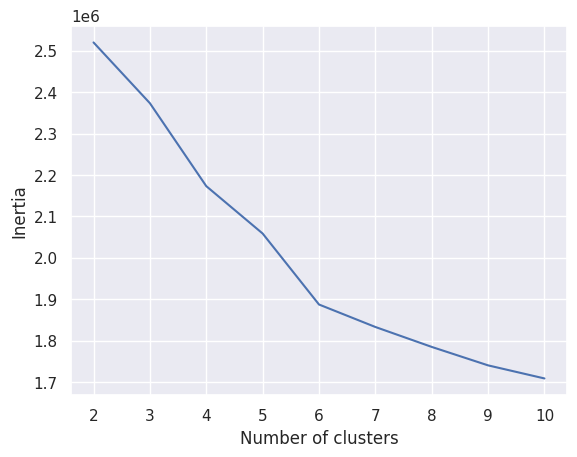

In [ ]:
sns.lineplot(x = num_clusters, y = inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Như chúng ta thấy, inertia giảm đáng kể khi số lượng cụm tăng từ 2 lên 6. Tuy nhiên, sau đó, sự khác biệt là ít hơn rất nhiều. Biểu đồ dường như mô tả một khuỷu tay ở sáu cụm, nhưng không có phương pháp rõ ràng để xác nhận rằng mô hình sáu cụm là tối ưu. Do đó, silhouette scores nên được kiểm tra.

In [ ]:
from sklearn.metrics import silhouette_score

num_clusters = [i for i in range(2,11)]
def kmeans_sil(num_clusters,x_values):
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters = num, random_state = 123)
        kms.fit(x_values)
        sil_score.append(silhouette_score(x_values,kms.labels_))
    return sil_score
sil_score = kmeans_sil(num_clusters,X_scaled)
sil_score

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[0.11384202924917596,
 0.08378672235561306,
 0.09733044020220576,
 0.10135162941927407,
 0.10753042384381566,
 0.09119078143909043,
 0.09486799926843298,
 0.09272066793678602,
 0.08920105803038962]

Tạo biểu đồ đường để xác định số cụm thích hợp nhất

Text(0, 0.5, 'Silhouette score')

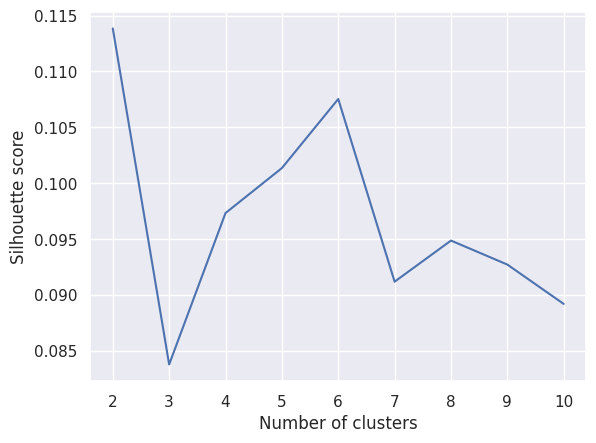

In [ ]:
sns.lineplot(x = num_clusters, y = sil_score)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')

- Điểm Silhouette gần 1 cho thấy các mẫu ở xa các cụm lân cận. Điểm gần bằng 0 cho thấy các mẫu nằm trên hoặc rất gần ranh giới quyết định giữa hai cụm lân cận.
- Biểu đồ chỉ ra rằng điểm Silhouette giảm đáng kể từ 2 xuống 3 cụm, sau đó tăng dần khi dữ liệu được phân chia thành sáu cụm. Vì vậy, 6 cụm mang lại điểm Silhouette tương đối tốt. Do đó, chúng ta chọn 6 là số cụm tối ưu để xây dựng mô hình KMeans.

<b>KMeans Modeling

In [ ]:
kmeans6 = KMeans(n_clusters = 6, random_state = 123)
kmeans6.fit(X_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=123)

Thêm 1 cột mới thể hiệm thứ tự cụm của mẫu dữ liệu

In [ ]:
df2['Cluster'] = kmeans6.labels_
df2

,Income,Age,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_HOUSE_YRS,Risk_Flag,PC1,PC2,Cluster
0,1303834,23,1,2,0,33,250,13,13,0,-1.480935,-0.188162,5
1,7574516,40,1,2,0,43,226,14,13,0,0.506973,-0.526866,4
2,3991815,66,0,2,0,47,8,12,10,0,-1.169251,-0.264246,0
3,6256451,41,1,2,1,43,53,17,12,1,-1.792620,-0.112078,2
4,5768871,47,1,2,0,11,295,22,14,1,-0.538533,0.754240,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,1,2,0,45,161,27,11,0,0.278721,0.408188,1
251996,2843572,26,1,2,0,3,250,13,11,0,-0.074680,0.054787,5
251997,4522448,46,1,2,0,17,143,14,12,0,-0.234197,-0.492498,5
251998,6507128,45,1,2,0,27,232,18,10,0,-2.415990,0.040091,5


In [ ]:
df2.groupby(['Cluster','Risk_Flag']).size()


Cluster  Risk_Flag
0        0            22533
         1             2600
1        0            35282
         1             4485
2        0            49596
         1             6662
3        0            16858
         1             1737
4        0            44338
         1             6774
5        0            52397
         1             8738
dtype: int64

- Số lượng không rủi ro (Risk_Flag = 0) luôn cao hơn đáng kể so với số lượng có rủi ro (Risk_Flag = 1) trong mỗi cụm.
- Cụm 2 và 5 có số lượng không rủi ro cao nhất, lần lượt là 49596 và 52397, điều này cho thấy hai cụm này có thể có các yếu tố mạnh mẽ hơn trong việc ngăn chặn rủi ro vỡ nợ.
- Cụm 3 có số lượng không rủi ro thấp nhất là 16858, nhưng cũng có tỷ lệ rủi ro thấp (1737 so với 16858), có thể là do cụm này nhỏ hơn các cụm khác.
- Tỷ lệ rủi ro vỡ nợ (Risk_Flag = 1) tăng dần từ cụm 0 đến 5, với cụm 5 có số lượng rủi ro cao nhất là 8738.